In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix, build_h_matrix
from aviso_rossby_wave import reverse_vector, forecast_ssh
from aviso_rossby_wave import build_swath, inversion, inversion2, make_error_over_time
import glob2 as glob


day0, day1 = 0, 30 # 150 day assimilation
Tdim = day1 - day0
start_date = '2016-06-01' ## starting date
n_waves = '190' #number of waves
exp = 1 # P_over_R = K^-1
MModes = 1 # Rossby wave vertical modes
wave_files = glob.glob('./rossby_wave_estimate_*_' + n_waves + 'waves.nc')
wave_files = sorted(wave_files)

alpha_std = np.arange(5e-4, 3.05e-2, 1e-3) # standard deviation of error paramters

lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east, :]
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data
T_time = avisso_ds.time.data[day0:] * 86400 # in seconds
date_time = avisso_ds.date_time.data[day0:]

rms_err, rms_ssh = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill2, err_est_skill2 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

ssh_est_skill1, err_est_skill1 = np.zeros([len(wave_files), len(alpha_std)]), np.zeros([len(wave_files), len(alpha_std)])

with tqdm(total= rms_err.size) as pbar:
    for n in range(len(wave_files)):
        wave_ds = xr.open_dataset(wave_files[n]) # forward model - filtered AVISO
        l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
        amp = wave_ds.Amplitudes.data
        time= wave_ds.time.data
        MSLA_fwd = wave_ds.MSLA_forward.data
        Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree
        l_n_orig, k_n_orig = wave_ds.l_n.data, wave_ds.k_n.data
        amp = wave_ds.Amplitudes.data
        time= wave_ds.time.data
        MSLA_fwd = wave_ds.MSLA_forward.data
        Rm = wave_ds.Rm.data # Rossby deformation radius, unit: degree

        Phi0 = lat.mean() # central latitude (φ0)
        Omega = 7.27e-5 # Ω is the angular speed of the earth
        Earth_radius = 6.371e6 / 1e5 # meters
        Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
        f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

        strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')
        Psi = strat_ds.Psi.data

        l_n = l_n_orig.reshape(len(l_n_orig), MModes)
        k_n = k_n_orig.reshape(len(k_n_orig), MModes)

        MSLA0 = MSLA_fwd[:, :, day0:day1]

        ### assess skill, get indices
        skill, SSHA_vector, Iindex, Jindex, Tindex = skill_matrix(MSLA0, Psi, l_n, k_n, MModes, Rm, lon, lat, T_time) # skill marrix

        M = k_n.size * l_n.size # Number of models/waves

        dlon = lon - lon.mean()
        dlat = lat - lat.mean()

        H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
        H_all = np.zeros([len(SSHA_vector), M * 2])
        omega = np.zeros([len(l_n), len(k_n), MModes])

        nn = 0
        for kk in range(len(l_n)):
            for ll in range(len(k_n)):
                for mm in range(MModes):
                    omega[kk, ll, mm] =  -(Beta * l_n[kk, mm]) / (l_n[kk, mm] ** 2 + k_n[ll, mm] ** 2 + Rm ** -2)
                    for count in range(len(Iindex)):
                        # (data, model)
                        H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[ll, mm] * dlon[int(Iindex[count])] + l_n[kk, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                        H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[ll, mm] * dlon[int(Iindex[count])] + l_n[kk, mm] * dlat[int(Jindex[count])] - omega[kk, ll, mm] * T_time[int(Tindex[count])])
                    nn += 1

        H_all[:, 0::2] = H_cos
        H_all[:, 1::2] = H_sin

        # signal to noise ratio R_over_P

        counter = 0
        exp = -2
        ssh_std = .1
        k0 = l_n.max() # flat at or below k0

        p_diagonal = np.zeros([2 * M])
        kl, kl_plot = np.zeros(M), np.zeros(2*M)
        k_, l_ = np.zeros(len(l_n)*len(k_n)), np.zeros(len(l_n)*len(k_n))
        counter = 0
        R = 0.01 # noise = 1. cm

        for kk in l_n:
            for ll in k_n:
                k_[counter] , l_[counter]  = kk, ll
                kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
                kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
                p_diagonal[2 * counter] = (kl[counter]+k0) ** exp
                p_diagonal[2 * counter + 1] = (kl[counter]+k0) ** exp
                counter += 1

        P_matrix = np.zeros([2 * M, 2 * M])
        p_factor = .16/p_diagonal.sum() # variance of the model,  convert sum of variance from waven number to meter
        np.fill_diagonal(P_matrix[:],  R / p_diagonal / p_factor)

        ## build satellite swath

        swath_width, x_swath = 6, 20
        days = np.arange(day0, day1)
        xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right = build_swath(swath_width, x_swath, days, lon, lat)

        # Loop over sigma
        sigma_counter = 0
        
        for sigma in alpha_std: # std of error amp

            # Add errors to the swaths
            mu = 0
            time_factor = np.arange(1, 1 + day1-day0)
            # generate error parameter with Gaussian distribution
            alpha = np.zeros([Tdim, 7]) #np.random.normal(mu, sigma, Tdim * 7).reshape(Tdim, 7) #
            for nn in range(7):
                alpha[:, nn] = np.random.normal(mu, sigma, Tdim) #TEST

            timing_err_valid, roll_err_valid, baseline_dilation_err_valid, phase_err_valid, xc1_valid, xc2_valid  = make_error_over_time(days, alpha, yswath_index_left, yswath_index_right, y_mask_left, y_mask_right)

            # sample SSH, errors and add white noise
            IND_TIMING = -7
            IND_ROLL = -6
            IND_BASELINE = -5
            IND_PHASE3, IND_PHASE4, IND_PHASE5, IND_PHASE6 = -4, -3, -2, -1

            #### Sub-sample the SSH, correlated errors and H matrix
            N = len(tindex) # number of data
            MSLA_swath = np.zeros(N)
            M = l_n.size * k_n.size
            nx, ny = len(lon), len(lat)
            H_swath = np.zeros([N, 2 * M + Tdim * 7]) # M: number of model
            IIndex = np.zeros(N) # N: Number of y data
            cor_err = np.zeros(N) # Correlated Error N: Number of y data
            Y_v = np.zeros(N)
            ssh = np.zeros(N)

            for ii in range(N):
                IIndex[ii] = nx * ny * tindex[ii] + ny * xvalid_index[ii] + yvalid_index[ii] # index in the vector space
                ssh[ii] = MSLA_fwd[xvalid_index[ii], yvalid_index[ii], int(tindex[ii])]
                cor_err[ii] = timing_err_valid.flatten()[ii] + roll_err_valid.flatten()[ii] + baseline_dilation_err_valid.flatten()[ii] + phase_err_valid.flatten()[ii]
                MSLA_swath[ii] = ssh[ii] + cor_err[ii] # filtered AVISO SSH , no error along the satellite passings
                for nn in range(M):
                    JIndex = 2 * MModes * nn # +  2 * mm # Model space
                    H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
                    H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

            Valid_points = len(xvalid_index) // Tdim
            err_basis_func = np.zeros([Valid_points, 7])
            for tt in range(Tdim):
                for ii in range(Valid_points):
                    #timing error
                    err_basis_func[ii, IND_TIMING] = 1 #  alpha_timing, TIMING ERR, distance from nadir Xc
                    # roll error = alpha[1] * Xc^1
                    err_basis_func[ii, IND_ROLL] = xc1_valid[tt, ii]  # alpha_roll, ROLL ERR, distance from nadir Xc
                    # baseline dialation error = alpha[2] * Xc^2
                    err_basis_func[ii, IND_BASELINE] = xc2_valid[tt, ii]  # alpha_base, BASELINE DIALATION ERR, distance from nadir Xc
                    # phase error
                    H_neg = np.heaviside(-1 * xc1_valid[tt, ii], 1) #
                    H_pos = np.heaviside(xc1_valid[tt, ii], 1) #
                    err_basis_func[ii, IND_PHASE3] = H_neg                 # alpha_phase3 * np.heaviside(xx - xc, 1)
                    err_basis_func[ii, IND_PHASE4] = xc1_valid[tt, ii] * H_neg # alpha_phase4 * Xc * np.heaviside(xx - xc, 1)
                    err_basis_func[ii, IND_PHASE5] = H_pos                 # alpha_phase5 * np.heaviside(xx + xc, 1)
                    err_basis_func[ii, IND_PHASE6] = xc1_valid[tt, ii] * H_pos # alpha_phase6 * np.heaviside(xx + xc, 1)

            ### fill the error basis function part of the H matrix
            for tt in range(Tdim):
                #print(2 * M + tt * 7 , 2 * M + (tt+1) * 7)
                H_swath[tt*Valid_points:(tt+1)*Valid_points, 2 * M + tt * 7 : 2 * M + (tt+1) * 7] = err_basis_func

            counter = 0
            exp = -2
            ssh_std = .1
            k0 = l_n.max() # flat at or below k0
            p_diagonal = np.zeros([2 * M + Tdim * 7])
            kl, kl_plot = np.zeros(M), np.zeros(2*M)
            k_, l_ = np.zeros(M), np.zeros(M)
            counter = 0
            R = 0.01 # noise = 10. cm

            for kk in l_n:
                for ll in k_n:
                    k_[counter] , l_[counter]  = kk, ll
                    kl[counter] =  np.sqrt(kk ** 2 + ll ** 2) # wavenumber
                    kl_plot[2 * counter], kl_plot[2 * counter + 1] = kl[counter], kl[counter]
                    p_diagonal[2 * counter] = (kl[counter] + k0) ** exp  * p_factor
                    p_diagonal[2 * counter + 1] = (kl[counter] + k0) ** exp  * p_factor
                    counter += 1

            p_diagonal[2*M:] = sigma ** 2 # errors

            P_matrix = np.zeros([2 * M + Tdim * 7, 2 * M +  Tdim * 7])

            np.fill_diagonal(P_matrix[:],  R / p_diagonal )

            Y_vector = Y_v
            H_matrix = H_swath

            # 1-stage approach, solve for amplitudes
            amp_swath, msla_estimated_swath = inversion(MSLA_swath, H_swath, P_matrix) # assimilate the filtered AVISO SSH + error

            # estimate the errors and ssh : H * amp
            err_est_1step = np.matmul(H_matrix[:, -7*Tdim:], amp_swath[-7*Tdim:])
            ssh_est_1step = np.matmul(H_matrix[:, :-7*Tdim], amp_swath[:-7*Tdim])

            # Important result: error estimate skill and ssh estimate skill of the entire time series
            ssh_diff = ssh_est_1step - ssh
            err_diff = err_est_1step - cor_err
            ssh_diff1 = np.sqrt(np.mean(ssh_diff**2)) / np.sqrt(np.mean(ssh**2))
            err_diff1  = np.sqrt(np.mean(err_diff**2)) / np.sqrt(np.mean(cor_err**2))

            HTH = np.matmul(H_matrix[:, -7 * Tdim:].T, H_matrix[:, -7 * Tdim:])

            # Two-stage approach: reconstructing the SSH separately from solving the correlated error

            # First step: fit errors
            H_v1 = H_swath[:, -7 * Tdim:]
            P_over_R1 = P_matrix[-7* Tdim:, -7* Tdim:]
            HTH = np.matmul(H_v1.T, H_v1)
            HRH = HTH + P_over_R1 # P: uncertainty in model, R: uncertainty in data
            D = np.matmul(LA.inv(HRH), H_v1.T)
            amp_err = np.matmul(D, MSLA_swath)

            err_est_2step = np.matmul(H_v1, amp_err) #### estimate the correlated error

            # second step: fit residual to rossby wave models

            H_v = H_swath[:, :-7 * Tdim]
            HTH = np.matmul(H_v.T, H_v)
            HRH = np.zeros(HTH.shape)
            HRH = HTH +  P_matrix[:-7 * Tdim, :-7 * Tdim]
            D = np.matmul(LA.inv(HRH), H_v.T)
            eig, vec = LA.eig(HRH)

            # second step: fit residual to rossby wave models
            tau_ssh = MSLA_swath - err_est_2step
            amp_swath_2step = np.matmul(D, tau_ssh)
            ssh_est_2step = np.matmul(H_v, amp_swath_2step) #### Reconstruct ssh with new amplitudes in the next 40 days

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_diff = ssh_est_2step - ssh
            err_diff = err_est_2step - cor_err
            ssh_diff_2stage = np.sqrt(np.mean(ssh_diff ** 2)) / np.sqrt(np.mean(ssh ** 2))
            err_diff_2stage = np.sqrt(np.mean(err_diff ** 2)) / np.sqrt(np.mean(cor_err ** 2))

            # Root mean squared err/ssh
            rms_err[n, sigma_counter] = np.sqrt(np.mean(cor_err ** 2))
            rms_ssh[n, sigma_counter]= np.sqrt(np.mean(ssh ** 2))

            # Important result: 2-stage error estimate skill and ssh estimate skill
            ssh_est_skill2[n, sigma_counter], err_est_skill2[n, sigma_counter] = (1 - ssh_diff_2stage.mean()) * 100, (1 - err_diff_2stage.mean()) * 100 # percentage,

            # Important result: 1-stage error estimate skill and ssh estimate skill
            ssh_est_skill1[n, sigma_counter], err_est_skill1[n, sigma_counter] = (1 - ssh_diff1.mean()) * 100, (1 - err_diff1.mean()) * 100 # percentage,

            sigma_counter += 1

            pbar.update(1)

100%|█████████████████████████████████████████| 210/210 [21:55<00:00,  6.26s/it]


In [2]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)

In [3]:
# only show error estimate skill greater than -100%
err_est_skill1 = np.ma.masked_less(err_est_skill1, -100)
err_est_skill2 = np.ma.masked_less(err_est_skill2, -100)

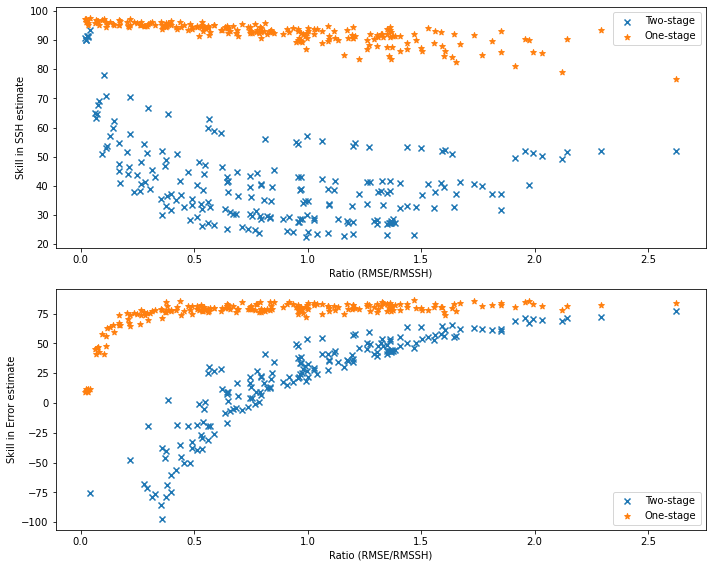

In [4]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh , ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')

axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Skill in SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Skill in Error estimate')

# Add titles
# axs[0].set_title('Skill in SSH estimate for different RMSE values')
# axs[1].set_title('Skill in Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()
#plt.show()
plt.savefig('skill_ssh_errr_rmse_ratio.png', dpi = 300)

In [5]:
rmse_over_rmssh = rms_err / rms_ssh
ratio_mean = rmse_over_rmssh.mean(axis = 0)
ssh_est_skill2_mean = ssh_est_skill2.mean(axis = 0)
ssh_est_skill1_mean = ssh_est_skill1.mean(axis = 0)
err_est_skill1_mean = err_est_skill1.mean(axis = 0)
err_est_skill2_mean = err_est_skill2.mean(axis = 0)

In [6]:
# only show error estimate skill greater than -100%
err_est_skill1_mean = np.ma.masked_less(err_est_skill1_mean, -100)
err_est_skill2_mean = np.ma.masked_less(err_est_skill2_mean, -100)

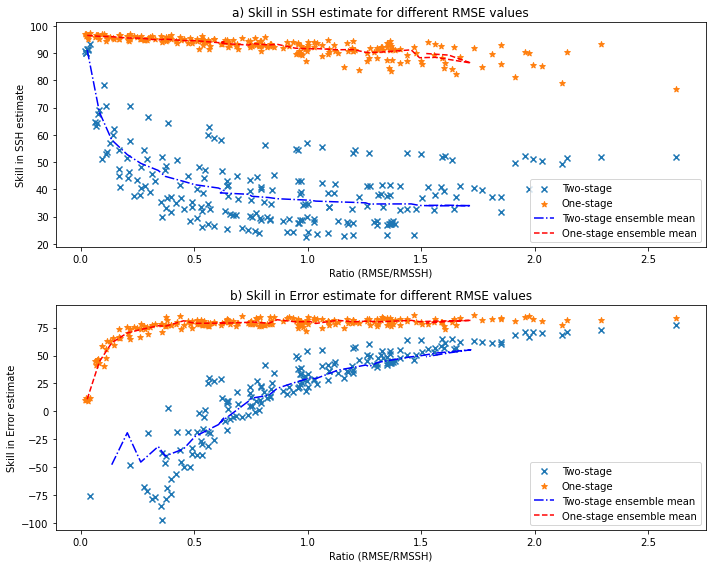

In [7]:
import matplotlib.pyplot as plt

# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 8))

# Plot data
axs[0].scatter(rmse_over_rmssh, ssh_est_skill2, marker='x', label='Two-stage')
axs[0].scatter(rmse_over_rmssh , ssh_est_skill1, marker='*', label='One-stage')
axs[0].plot(ratio_mean , ssh_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[0].plot(ratio_mean, ssh_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')


axs[1].scatter(rmse_over_rmssh , err_est_skill2, marker='x', label='Two-stage')
axs[1].scatter(rmse_over_rmssh , err_est_skill1, marker='*', label='One-stage')
axs[1].plot(ratio_mean , err_est_skill2_mean, linestyle = '-.', color = 'b', label='Two-stage ensemble mean')
axs[1].plot(ratio_mean , err_est_skill1_mean, linestyle = '--', color = 'r', label='One-stage ensemble mean')

# Label axes
axs[0].set_xlabel('Ratio (RMSE/RMSSH)')
axs[0].set_ylabel('Skill in SSH estimate')
axs[1].set_xlabel('Ratio (RMSE/RMSSH)')
axs[1].set_ylabel('Skill in Error estimate')

# Add titles
axs[0].set_title('a) Skill in SSH estimate for different RMSE values')
axs[1].set_title('b) Skill in Error estimate for different RMSE values')

# Add legends
axs[0].legend()
axs[1].legend()

# Show plots
plt.tight_layout()

plt.savefig('skill_ssh_errr_rmse_ratio_mean.png', dpi = 300)

In [8]:
ratio_mean * 100, alpha_std, rmse_over_rmssh[:, 0]

(array([  2.88860562,   8.26959143,  13.69495077,  20.55620151,
         26.49556405,  34.18597128,  37.27024639,  45.34728508,
         50.42341575,  60.74481125,  63.19863787,  61.56005038,
         74.07254414,  75.46217997,  82.8613533 ,  86.59927655,
         94.55230229, 101.16152821, 103.57264157, 113.22999523,
        119.9586198 , 125.61805155, 127.10498215, 130.910797  ,
        145.60255576, 149.30870332, 156.39041983, 171.92477204,
        162.19976406, 152.15840546]),
 array([0.0005, 0.0015, 0.0025, 0.0035, 0.0045, 0.0055, 0.0065, 0.0075,
        0.0085, 0.0095, 0.0105, 0.0115, 0.0125, 0.0135, 0.0145, 0.0155,
        0.0165, 0.0175, 0.0185, 0.0195, 0.0205, 0.0215, 0.0225, 0.0235,
        0.0245, 0.0255, 0.0265, 0.0275, 0.0285, 0.0295]),
 array([0.04275712, 0.03202826, 0.02922017, 0.02534436, 0.02233464,
        0.02026851, 0.03024933]))

In [9]:
ssh_est_skill2_mean

array([91.19051129, 68.32669178, 58.14909567, 52.72713326, 49.52467399,
       46.925408  , 44.74186419, 42.90595548, 41.67528105, 40.4568846 ,
       39.49484254, 38.67944447, 38.16451026, 37.43133286, 36.97091601,
       36.53817134, 36.22327866, 35.97737615, 35.65856022, 35.37161788,
       35.20418559, 35.02013878, 34.56123342, 34.60714872, 34.63021441,
       34.05711753, 33.91249384, 33.98460306, 34.14044558, 34.09364325])

In [10]:
ssh_est_skill1_mean

array([96.5327376 , 96.1927298 , 96.06460157, 95.57733469, 95.5103287 ,
       94.83457309, 95.17791536, 94.63911994, 94.6002526 , 93.86377014,
       94.15253173, 93.62171585, 92.97978983, 93.53841272, 93.01496942,
       93.25865376, 91.83705553, 91.58694718, 91.70093641, 91.26132035,
       91.31849529, 90.33403273, 90.23679107, 90.32385469, 91.21691163,
       88.32520849, 88.48332553, 86.39321744, 89.29134375, 89.86895408])

In [11]:
ssh_est_1step

array([-0.00990055, -0.01316493, -0.00792782, ..., -0.02316938,
       -0.03345993, -0.0003739 ])

In [12]:
# mean error in meters
rms_err.mean(axis = 0)

array([0.0023555 , 0.006809  , 0.0110986 , 0.01697869, 0.02162255,
       0.02760495, 0.03054168, 0.03748305, 0.04183429, 0.04909789,
       0.05179466, 0.05032513, 0.06078651, 0.06271693, 0.06748984,
       0.07125759, 0.07803537, 0.08302185, 0.08430553, 0.09296701,
       0.09874887, 0.10264113, 0.10298131, 0.10818663, 0.11955336,
       0.12270004, 0.12948259, 0.14079589, 0.13246131, 0.12450941])

In [13]:
err_est_skill1_mean

masked_array(data=[10.83928279, 44.51136837, 61.45530636, 70.29479957,
                   73.35081465, 76.74248542, 76.28869359, 81.17451483,
                   78.9165702 , 79.05465696, 79.64010639, 78.85543144,
                   79.84374015, 80.13595764, 78.91561435, 82.1374776 ,
                   80.27546766, 80.46142681, 78.77271722, 81.65593028,
                   80.24829283, 80.77374259, 80.874577  , 80.23185291,
                   81.59682788, 80.41472778, 80.9051685 , 81.5554195 ,
                   80.64347156, 79.12633214],
             mask=False,
       fill_value=1e+20)